In [1]:
""""
Experiment to check how a Random Forest Classifier reacts against
modifications in the synthetic testing datasets.
"""

import torch
from data import load_csv_to_df, train_test_split_stratify
from graph import get_flow_features_values, get_encoded_label
import configparser
from sklearn.ensemble import RandomForestClassifier
from data import modify_portscan_attack_behavior
import os
import metrics

source_code_dir = '/home/dev/src'

print(os.getcwd())

config = configparser.ConfigParser()
config.read(source_code_dir+"/config.ini")

model = RandomForestClassifier()

data = load_csv_to_df(
    config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["TrainFile"])

# test = load_csv_to_df(
#     config["PARAMETERS"]["DataFolderPath"] + config["PARAMETERS"]["EvalFile"])

# 데이터 셋 분리 
train,test  = train_test_split_stratify(data,0.3)

print('train_data label rate',train[' Label'].value_counts())
print()
print('test_data label rate',test[' Label'].value_counts())





/home/dev/src
train_data label rate  Label
PortScan    127144
BENIGN      102029
Name: count, dtype: int64

test_data label rate  Label
PortScan    31786
BENIGN      25508
Name: count, dtype: int64


In [2]:

labels_map = {"BENIGN": 0, "PortScan": 1}
labels = ["BENIGN", "PortScan"]

flow_features = [    
    " Flow Duration",
    " Flow Packets/s",
    " Flow IAT Mean",
    " Fwd IAT Mean",
    " Bwd IAT Mean",]

# flow_features = [
#     " Average Packet Size",
#     " Flow IAT Mean",
#     " Flow Duration",
# ]


test = modify_portscan_attack_behavior(test)


In [4]:
# train vectors
x_train = []
y_train = []
for _, row in train.iterrows():
    x_train.append(get_flow_features_values(row, flow_features))
    y_train.append(get_encoded_label(
        row, labels_map))

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

# test vectors
x_test = []
y_test = []
for _, row in test.iterrows():
    x_test.append(get_flow_features_values(row, flow_features))
    y_test.append(get_encoded_label(
        row, labels_map))

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)



In [5]:
x_train

tensor([[6.2496e+04, 6.4004e+01, 2.0832e+04, 1.0000e+00, 3.0000e+00],
        [1.3000e+01, 1.5385e+05, 1.3000e+01, 0.0000e+00, 0.0000e+00],
        [1.7200e+02, 2.3256e+04, 5.7333e+01, 4.0000e+00, 4.0000e+00],
        ...,
        [2.2000e+01, 9.0909e+04, 2.2000e+01, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 9.5238e+04, 2.1000e+01, 0.0000e+00, 0.0000e+00],
        [4.9000e+01, 4.0816e+04, 4.9000e+01, 0.0000e+00, 0.0000e+00]])

## Model Train

In [6]:

print("Training model...")
model.fit(x_train, y_train)
print("Evaluating model...")

print(model.score(x_test, y_test))

Training model...
Evaluating model...
0.9628058784514958


In [12]:
import metrics
pred = model.predict(x_test)
metrics.compute_metrics(y_test, pred)

{'F1 Score': 0.962571317519216,
 'Accuracy': 0.9633249700010909,
 'Recall': 0.9592951347120982,
 'Precision': 0.9679822953069751}

[0.33039408 0.21048697 0.09912883 0.31883575 0.04115436] 

 Flow Duration     0.330394
 Fwd IAT Mean      0.318836
 Flow Packets/s    0.210487
 Flow IAT Mean     0.099129
 Bwd IAT Mean      0.041154
dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


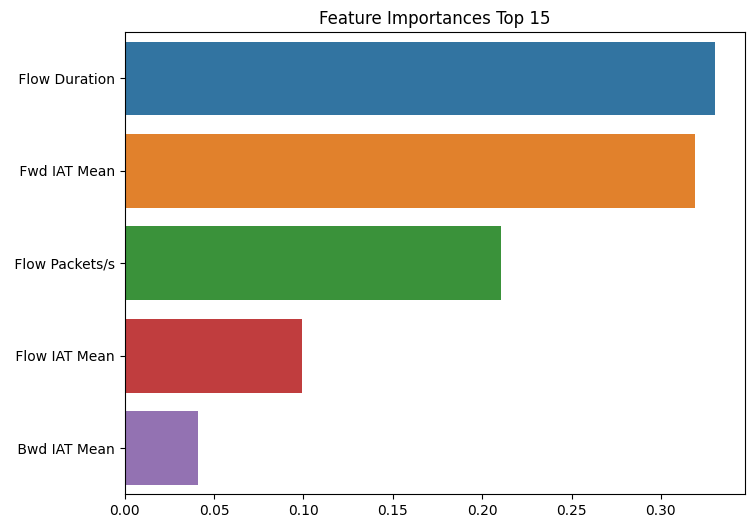

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rf = model

# 그냥 확인하기에 피쳐종류가 30개나 되어 한눈에 들어오지 않는다.
print(rf.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(rf.feature_importances_, index=flow_features)

# 내림차순 정렬을 이용한다
top15 = ser.sort_values(ascending=False)[:15]
print(top15)


plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 15')
sns.barplot(x=top15, y=top15.index)
plt.show()